In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, plot_confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, log_loss, precision_score
from sklearn.preprocessing import OneHotEncoder
import copy

%matplotlib inline

In [2]:
# Quick import of cleaned/imputed data
complete_df = pd.read_csv('data/update1.csv').drop(columns='Unnamed: 0')

In [3]:
# One hot encode the specified columns, remove the original columns, append the 
# encoded columns, and return df

def create_ohe_df(df, col_list):
    df2 = copy.copy(df)
    
    temp_df = df[col_list] 
    df2 = df2.drop(columns=col_list)
    
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(temp_df)
    one_hot_df = enc.transform(temp_df)
    
    return pd.concat([df2, pd.DataFrame(one_hot_df.todense())], axis=1)


In [4]:
OHE_df = create_ohe_df(complete_df, ['Ethnicity', 'Gender', 'Been_Arrested', 
                                         'State', 'Work_Situation'])

In [5]:
cluster_df = copy.copy(OHE_df)

In [6]:
# add target feature according to Average Drinking feature

cluster_df['target'] = cluster_df['Average_Drinking'].map(lambda x: 0 if x==11
                                                                  else 1 if x>=7 and x<=10
                                                                    else 2 if x<=5
                                                                     else None)

# filter df by values in Average Drinking which belong to a label
train_df = cluster_df[cluster_df['target'].notnull()]
train_df = train_df.drop(columns=['Beer_Frequency', 'Liquor_Frequency', 'Wine_Frequency', 
                                  'Average_Drinking']);

In [7]:
# Function to balance all labels equally depending on the size of the minority.
# Percent argument determines the sample size by increasing the minority size by the 
# specified percentage. All labels under this threshold are oversampled, and all 
# labels over the threshold are undersampled.

def balance_classes(train_df, percent):
    
    zeros = train_df[train_df['target'] == 0]
    ones = train_df[train_df['target'] == 1]
    twos = train_df[train_df['target'] == 2]

    # Make list of labels which have more than 0 data points
    label_list = [ones, twos, zeros]
    non_zero_labels = []
    for label in label_list:
        if label.shape[0] != 0:
            non_zero_labels.append(label)
        
    # get list of sized of labels to find the minority
    labels = []
    for label in non_zero_labels:
        labels.append(label.shape[0])
    
    minority = np.min(labels)
    total_rows = twos.shape[0]+ones.shape[0]+zeros.shape[0]
    
    # Calculate the target number of data points for each class
    target_num = int(total_rows * ((minority/total_rows) + (minority/total_rows) * percent)) 
    
    # resample all labels accoprding to the target sample size
    resampled_zeros = resample(zeros, n_samples=target_num, stratify=zeros)
    resampled_ones = resample(ones, n_samples=target_num, stratify=ones)
    resampled_twos = resample(twos, n_samples=target_num, stratify=twos)
    
    # create new dataframe containing all resampled labels
    train_df = pd.concat([resampled_zeros, resampled_ones, resampled_twos], 
                         ignore_index=True)
    
    
    return train_df 

In [8]:
train_df = balance_classes(train_df, .3)

In [9]:
# Create X and y for train_test_split

def convert_split(target_col):    

    X = train_df.drop(columns=target_col)
    y = train_df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test= convert_split('target')

In [29]:
# Create GB model, print the accuracy,log loss and confusion matrix

def create_GB_model():
    GB_model = GradientBoostingClassifier(learning_rate=0.08, max_depth=12, n_estimators=1200, 
                                      min_samples_split=10, min_samples_leaf=4)
    GB_model.fit(X_train, y_train)

    GB_train_predict = GB_model.predict(X_train)
    GB_train_proba = GB_model.predict_proba(X_train)
    GB_test_predict = GB_model.predict(X_test)
    
    print(f'Acc: {accuracy_score(y_test, GB_test_predict)}')
    print(f'Loss: {log_loss(y_train, GB_train_proba)}')
    RF_conf = plot_confusion_matrix(GB_model, X_test ,y_test ,normalize='true',cmap='YlOrRd')
    RF_conf.ax_.grid(False)
    RF_conf.ax_.set_title('GB 3 Balanced Classes');
    

In [31]:
# Create RF model, print the accuracy,log loss and confusion matrix

def create_RF_model(max_depth=10, n_estimators=600, min_samples_split=6, min_samples_leaf=4):
    RF_model = RandomForestClassifier(max_depth = max_depth, 
                                      n_estimators = n_estimators, 
                                      min_samples_split = min_samples_split, 
                                      min_samples_leaf = min_samples_leaf)
    RF_model.fit(X_train, y_train)

    train_predict = RF_model.predict(X_train)
    train_proba = RF_model.predict_proba(X_train)
    test_predict = RF_model.predict(X_test)
    '''
    scores.extend([min_samples_split, 
                   accuracy_score(y_test, test_predict), 
                   log_loss(y_train, train_proba)])
    '''
    print(f'Acc: {accuracy_score(y_test, RF_test_predict)}')
    print(f'Loss: {log_loss(y_train, RF_train_proba)}')
    RF_conf = plot_confusion_matrix(RF_model, X_test ,y_test ,normalize='true',cmap='YlOrRd')
    RF_conf.ax_.grid(False)
    RF_conf.ax_.set_title('RF 3 Balanced Classes');


[10, 0.6083027393391697, 0.7640639414281043]

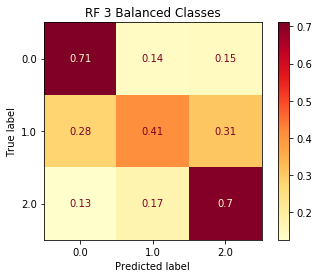

In [17]:
# max_depth=20, n_estimators=800, min_samples_split=10, min_samples_leaf=4
#
create_RF_model()

In [32]:
# max_depth=10, n_estimators=600, min_samples_split=6, min_samples_leaf=4
#
create_RF_model()

NameError: name 'RF_test_predict' is not defined

Acc: 0.5888167184411184
Loss: 0.7066484487918383


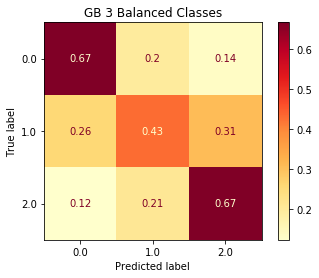

In [28]:
# learning_rate=0.03, max_depth=4, n_estimators=800, 
# min_samples_split=10, min_samples_leaf=4
create_GB_model()

Acc: 0.5930528099406948
Loss: 0.0002942909756840503


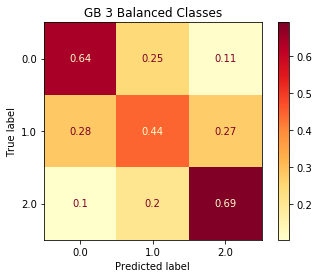

In [30]:
# learning_rate=0.08, max_depth=12, n_estimators=1200, 
# min_samples_split=10, min_samples_leaf=4
create_GB_model()

In [12]:
list1 = [4,8]
score_list=[]
for value in list1:
    score_list.append(create_RF_model(min_samples_split=value))

In [14]:
plot_df4 = pd.DataFrame(score_list, columns=['min_samples_split', 'Acc', 'Loss']).set_index('min_samples_split')

In [13]:
score_list

[[4, 0.608020333239198, 0.7592752883937549],
 [8, 0.6099971759390003, 0.7590762292254586]]

In [ ]:
# Gradient Boosting
# 2 classes balanced

print(f'Accuracy: {accuracy_score(y_test, GB_test_predict)}')
print(f'Log Loss:: {log_loss(y_train, GB_train_proba)}')

GB_conf = plot_confusion_matrix(GB_model, X_train ,y_train ,normalize='true',cmap='YlOrRd')
GB_conf.ax_.grid(False)
GB_conf.ax_.set_title('Gradient Boosting 2 Balanced Classes');

In [ ]:
def gradient_class_grid_search():
    
    params = {
        'learning_rate':[.03,.05,.06,.08],
        'n_estimators':[300, 400],
        'min_samples_split':[8, 10],
        'min_samples_leaf':[2,4],
        'max_depth':[4, 5, 7],
        'warm_start':[True, False]}
        
    gg_gridsearch = GridSearchCV(GradientBoostingClassifier(), 
                  params,
                  n_jobs=-1,
                  verbose=True,
                  scoring='neg_log_loss')

    gg_gridsearch.fit(X_train, y_train)
    
    print(gg_gridsearch.best_params_)
    return gg_gridsearch.best_params_


best_accuracy = {'learning_rate': 0.03,
         'max_depth': 5,
         'min_samples_leaf': 2,
         'min_samples_split': 10,
         'n_estimators': 300}

In [ ]:
LR = LogisticRegression(fit_intercept=True, penalty='l2', solver='sag', warm_start=True, C=.8)
RF = RandomForestClassifier(n_estimators=800 ,max_depth=4, min_samples_split=10, min_samples_leaf=4)
GB = GradientBoostingClassifier(learning_rate=0.03, max_depth=4, n_estimators=800, 
                                      min_samples_split=10, min_samples_leaf=4)

In [ ]:
conf_LR = plot_confusion_matrix(LR, X_train_one_hot ,y_train ,normalize='true',cmap='YlOrRd')
conf_RF = plot_confusion_matrix(RF, X_train_one_hot ,y_train ,normalize='true',cmap='YlOrRd')
conf_GB = plot_confusion_matrix(GB, X_train_one_hot ,y_train ,normalize='true',cmap='YlOrRd')
conf_LR.ax_.grid(False)
conf_RF.ax_.grid(False)
conf_GB.ax_.grid(False)
conf_LR.ax_.set_title('Logistic Regression Confusion Matrix')
conf_RF.ax_.set_title('Random Forest Confusion Matrix')
conf_GB.ax_.set_title('Gradient Boosting Confusion Matrix')

In [ ]:
feature_importances = GB_model.feature_importances_
names = np.array(list(X_train.columns))

fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Gradient Boosting Feature Importance', fontsize=14)
ax.bar(names, feature_importances)
ax.set_xticklabels(labels=names, rotation=90, fontsize=12);

#fig.savefig('Gradient_Boosting_Feature_Importance')
plt.tight_layout()

In [ ]:
classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    AdaBoostClassifier(),
    GaussianNB(),
    #QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(),
    LogisticRegression(max_iter=1000),
    GradientBoostingClassifier()]

print(f'    {len(np.unique(y_train))} Labels')
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    train_proba = clf.predict_proba(X_train)
    acc = accuracy_score(y_test, train_predictions)
    loss = log_loss(y_train, train_proba)
    print("Accuracy: {:.4%}".format(acc))
    print("Log Loss: {:.4%}".format(loss))
    